<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cleaning-of-Imerge-3-way-merged-df" data-toc-modified-id="Cleaning-of-Imerge-3-way-merged-df-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cleaning of Imerge 3 way merged df</a></span></li><li><span><a href="#EDA-of-Beneficiary-Demographics-Grouped-by-Provider:-Race-and-Sex" data-toc-modified-id="EDA-of-Beneficiary-Demographics-Grouped-by-Provider:-Race-and-Sex-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA of Beneficiary Demographics Grouped by Provider: Race and Sex</a></span><ul class="toc-item"><li><span><a href="#Race" data-toc-modified-id="Race-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Race</a></span></li><li><span><a href="#Sex/Gender-1-=-MALE-2-=-FEMALE" data-toc-modified-id="Sex/Gender-1-=-MALE-2-=-FEMALE-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sex/Gender 1 = MALE 2 = FEMALE</a></span></li><li><span><a href="#Fraction-Deceased" data-toc-modified-id="Fraction-Deceased-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fraction Deceased</a></span></li></ul></li><li><span><a href="#Are-physicians-shared-between-providers?" data-toc-modified-id="Are-physicians-shared-between-providers?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Are physicians shared between providers?</a></span><ul class="toc-item"><li><span><a href="#Attending-Physicians:-128-attending-physicians-work-at-2-or-3-providers" data-toc-modified-id="Attending-Physicians:-128-attending-physicians-work-at-2-or-3-providers-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Attending Physicians: 128 attending physicians work at 2 or 3 providers</a></span></li><li><span><a href="#operating-Physicians:-63-work-at-2-providers" data-toc-modified-id="operating-Physicians:-63-work-at-2-providers-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>operating Physicians: 63 work at 2 providers</a></span></li><li><span><a href="#Other-Physicians:-16-work-at-2-or-3-providers" data-toc-modified-id="Other-Physicians:-16-work-at-2-or-3-providers-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Other Physicians: 16 work at 2 or 3 providers</a></span></li><li><span><a href="#Note-that-530-(of-40474-total)-physicans-change-between-Attending,-Operating-and-Other" data-toc-modified-id="Note-that-530-(of-40474-total)-physicans-change-between-Attending,-Operating-and-Other-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Note that 530 (of 40474 total) physicans change between Attending, Operating and Other</a></span></li><li><span><a href="#Number-of-physicians-that-work-at-more-than-one-provider-=-206,-of-which-only-2-change-between-Att,-Opr,-Oth" data-toc-modified-id="Number-of-physicians-that-work-at-more-than-one-provider-=-206,-of-which-only-2-change-between-Att,-Opr,-Oth-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Number of physicians that work at more than one provider = 206, of which only 2 change between Att, Opr, Oth</a></span></li><li><span><a href="#But-maybe-just-having-any-Operating-Physician-or-Other-Physician-is-associated-with-fraud-providers?" data-toc-modified-id="But-maybe-just-having-any-Operating-Physician-or-Other-Physician-is-associated-with-fraud-providers?-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>But maybe just having any Operating Physician or Other Physician is associated with fraud providers?</a></span></li><li><span><a href="#Conclusions-for-analysis-of-physicians:" data-toc-modified-id="Conclusions-for-analysis-of-physicians:-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Conclusions for analysis of physicians:</a></span></li></ul></li><li><span><a href="#Relationship-of-Fraud-and-Beneficiary-Age" data-toc-modified-id="Relationship-of-Fraud-and-Beneficiary-Age-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Relationship of Fraud and Beneficiary Age</a></span></li><li><span><a href="#Feature-engineering-of-Imerge-dataframe" data-toc-modified-id="Feature-engineering-of-Imerge-dataframe-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature engineering of Imerge dataframe</a></span></li><li><span><a href="#One-Hot-and-Label-Encoding-of-trIeng_df-dataframe" data-toc-modified-id="One-Hot-and-Label-Encoding-of-trIeng_df-dataframe-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>One Hot and Label Encoding of trIeng_df dataframe</a></span></li><li><span><a href="#testing-dummified-and-label-encoded-dfs-with-t-distributed-Stochastic-Neighbor-Embedding" data-toc-modified-id="testing-dummified-and-label-encoded-dfs-with-t-distributed-Stochastic-Neighbor-Embedding-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>testing dummified and label encoded dfs with t-distributed Stochastic Neighbor Embedding</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size*1.1,
          'axes.titlesize': size*2,
          'xtick.labelsize': size*1.1,
          'ytick.labelsize': size*1.1,
          'axes.titlepad': 25,
          'figure.titlesize': size*2,
          'legend.fontsize': size,
            'legend.title_fontsize': size*1.1
         }

plt.rcParams.update(params)

sns.set_style("whitegrid")

In [125]:
# read in dataframes from binaries
trB= pd.read_pickle("./data/trB.pkl") # Train Beneficiaries 
trO= pd.read_pickle("./data/trO.pkl") # Train Outpatient Claims
trI= pd.read_pickle("./data/trI.pkl") # Train Inpatient Claims
trF= pd.read_pickle("./data/trF.pkl") # Train Provider Fraud

In [126]:
# three way merge of Inpatient claims, drop uneeded columns and 'ClmProcedureCode_6' which is empty
Imerge = trF.merge(trI.merge(trB, on='BeneID'), on='Provider').drop(['index','index_x','index_y', 'DOB', 'ClaimID','ClmProcedureCode_6','DeductibleAmtPaid' ], axis=1)

# Cleaning of Imerge 3 way merged df

In [127]:
# convert potentialfraud to binary

vals = {'Yes' : 1, 'No' : 0} 
Imerge['PotentialFraud'] = Imerge['PotentialFraud'].map(vals)


In [128]:
# feature engineering: Add features: calculate days between ClaimStartDt-ClaimEndDt, AdmissionDt-DischargeDt
# convert to datetime
Imerge['ClaimStartDt']= pd.to_datetime(Imerge['ClaimStartDt'])
Imerge['ClaimEndDt']= pd.to_datetime(Imerge['ClaimEndDt'])
Imerge['AdmissionDt']= pd.to_datetime(Imerge['AdmissionDt'])
Imerge['DischargeDt']= pd.to_datetime(Imerge['DischargeDt'])

# days of admission and claim duration
Imerge['ClaimDuration'] =(Imerge['ClaimEndDt']- Imerge['ClaimStartDt']).dt.days
Imerge['AdmitDays'] =(Imerge['DischargeDt']- Imerge['AdmissionDt']).dt.days

# change dates to day of year
Imerge['ClaimStartDt']= Imerge['ClaimStartDt'].apply(lambda x: x.timetuple().tm_yday)
Imerge['ClaimEndDt']= Imerge['ClaimEndDt'].apply(lambda x: x.timetuple().tm_yday)
Imerge['AdmissionDt']= Imerge['AdmissionDt'].apply(lambda x: x.timetuple().tm_yday)
Imerge['DischargeDt']= Imerge['DischargeDt'].apply(lambda x: x.timetuple().tm_yday)

In [130]:
# Change DOD to binary

Imerge['DOD'].loc[~Imerge['DOD'].isnull()] = 1 # returns warning but still works
Imerge['DOD'].fillna(0, inplace = True)
Imerge['DOD']= Imerge['DOD'].astype('int64')

/Users/RK/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [131]:
Imerge['DOD'].value_counts()

0    40156
1      318
Name: DOD, dtype: int64

In [136]:

Imerge['Gender'].value_counts()
# 2    23267
# 1    17207
# Name: Gender, dtype: int64


# Gender to binary 1= male, 0= female

Imerge['Gender'] = Imerge['Gender'].map({2 : 0, 1 : 1})

In [133]:
# 1    34126
# 2     4202
# 3     1359
# 5      787
# Name: Race, dtype: int64


# Race to binary 1= white, 0 = not white
#Imerge[(Imerge['Race']==2) | (Imerge['Race']==3) |(Imerge['Race']==5) ] = 0

Imerge['Race'] = Imerge['Race'].map({1 : 1, 2 : 0, 3 : 0, 5 : 0})

In [137]:
Imerge['Gender'].value_counts()

0    23267
1    17207
Name: Gender, dtype: int64

In [138]:
# sum number of diagnostic or procedure codes and add into new columns

diag=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
proc=['ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5']

Imerge['numDiagCodes'] = Imerge[diag].count(1)
Imerge['numProcCodes'] = Imerge[proc].count(1)

In [139]:
# sum number of physicians and add into new column
phys = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
Imerge['numPhysicians'] = Imerge[phys].count(1)

In [140]:
# Fix 'RenalDiseaseIndicator' column: '0' to 2, 'Y' to 1
# trB['RenalDiseaseIndicator'] = np.where(trB['RenalDiseaseIndicator']=='0', 2, trB['RenalDiseaseIndicator'])
# trB['RenalDiseaseIndicator'] = np.where(trB['RenalDiseaseIndicator']=='Y', 1, trB['RenalDiseaseIndicator'])
# trB['RenalDiseaseIndicator']= trB['RenalDiseaseIndicator'].astype('int64')


# Change chronic conditions to binary

ccols=['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke']

Imerge[ccols] = np.where(Imerge[ccols]==2, 0, Imerge[ccols])

In [141]:
# Average Reimbursment per day per claim
Imerge['ReimbPerDayAdmit']= (Imerge['InscClaimAmtReimbursed']/(Imerge['AdmitDays']+0.001)).astype('int64')


In [142]:
Imerge.to_pickle("./data/Imerge.pkl")

In [123]:
Imerge= pd.read_pickle("./data/Imerge.pkl")

In [60]:
potentialFraud_df = pd.DataFrame(potentialFraud_df.apply(lambda x: x.name)).reset_index().drop(columns=[0])

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51007,No
3,PRV51008,No
4,PRV51011,No
...,...,...
2087,PRV57719,No
2088,PRV57728,No
2089,PRV57729,No
2090,PRV57732,No


In [30]:
# Number unique beneficiaries per provider
numBene_df = Imerge.groupby(['Provider'])['BeneID'].apply(pd.Series.nunique).to_frame(name='numBene').reset_index()

In [28]:
numBene_df

,Provider,numBene
0,PRV51001,5
1,PRV51003,53
2,PRV51007,3
3,PRV51008,2
4,PRV51011,1
...,...,...
2087,PRV57719,4
2088,PRV57728,1
2089,PRV57729,10
2090,PRV57732,11


In [29]:
# Number unique claims per provider
numClaim_df = Imerge.groupby(['Provider'])['BeneID'].count().to_frame(name='numClaim').reset_index()

# EDA of Beneficiary Demographics Grouped by Provider: Race and Sex

## Race

In [20]:
Imerge['Race'].value_counts()

1    34126
2     4202
3     1359
5      787
Name: Race, dtype: int64

In [278]:
Imerge_race= Imerge.groupby(['Provider','PotentialFraud','Race']).size().to_frame(name='size').reset_index()

In [284]:
Imerge_race_pivot= Imerge_race.pivot_table(columns='Race', index=['Provider', 'PotentialFraud'],values='size')
print(Imerge_race_pivot)

Race                        1     2   3    5
Provider PotentialFraud                     
PRV51001 0                5.0   NaN NaN  NaN
PRV51003 1               49.0  13.0 NaN  NaN
PRV51007 0                3.0   NaN NaN  NaN
PRV51008 0                2.0   NaN NaN  NaN
PRV51011 0                1.0   NaN NaN  NaN
...                       ...   ...  ..  ...
PRV57719 0                4.0   NaN NaN  NaN
PRV57728 0                1.0   NaN NaN  NaN
PRV57729 0                8.0   2.0 NaN  1.0
PRV57732 0                9.0   1.0 NaN  1.0
PRV57757 0               10.0   NaN NaN  1.0

[2092 rows x 4 columns]


In [302]:
Imerge_race_pivot.reset_index(inplace=True)


In [301]:
Imerge_race_pivot.iloc[:,-4:].sum(1).values

array([ 5., 62.,  3., ..., 11., 11., 11.])

In [303]:
Imerge_race_pivot['Rsum']=Imerge_race_pivot.iloc[:,-4:].sum(1).values

In [304]:
Imerge_race_pivot

Race,index,Provider,PotentialFraud,1,2,3,5,Rsum
0,0,PRV51001,0,5.0,NaN,NaN,NaN,5.0
1,1,PRV51003,1,49.0,13.0,NaN,NaN,62.0
2,2,PRV51007,0,3.0,NaN,NaN,NaN,3.0
3,3,PRV51008,0,2.0,NaN,NaN,NaN,2.0
4,4,PRV51011,0,1.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
2087,2087,PRV57719,0,4.0,NaN,NaN,NaN,4.0
2088,2088,PRV57728,0,1.0,NaN,NaN,NaN,1.0
2089,2089,PRV57729,0,8.0,2.0,NaN,1.0,11.0
2090,2090,PRV57732,0,9.0,1.0,NaN,1.0,11.0


In [311]:
Imerge_race_pivot.iloc[:,-5:-1].apply(lambda x: x/Imerge_race_pivot.Rsum, axis=0).reset_index()

Race,index,1,2,3,5
0,0,1.000000,NaN,NaN,NaN
1,1,0.790323,0.209677,NaN,NaN
2,2,1.000000,NaN,NaN,NaN
3,3,1.000000,NaN,NaN,NaN
4,4,1.000000,NaN,NaN,NaN
...,...,...,...,...,...
2087,2087,1.000000,NaN,NaN,NaN
2088,2088,1.000000,NaN,NaN,NaN
2089,2089,0.727273,0.181818,NaN,0.090909
2090,2090,0.818182,0.090909,NaN,0.090909


In [330]:
Imerge_race_pivot_ratio= Imerge_race_pivot.iloc[:,-5:-1].apply(lambda x: x/Imerge_race_pivot.Rsum, axis=0).reset_index()
Imerge_race_pivot_ratio.fillna(0, inplace = True)
Imerge_race_pivot_ratio['not_white']=Imerge_race_pivot_ratio[2]+Imerge_race_pivot_ratio[3]+Imerge_race_pivot_ratio[5]
Imerge_race_pivot_ratio['other_hispanic']=Imerge_race_pivot_ratio[3]+Imerge_race_pivot_ratio[5]
Imerge_race_pivot_ratio = pd.concat([Imerge_race_pivot[['Provider','PotentialFraud']], Imerge_race_pivot_ratio], axis=1)

In [331]:
Imerge_race_pivot_ratio

Race,Provider,PotentialFraud,index,1,2,3,5,not_white,other_hispanic
0,PRV51001,0,0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,PRV51003,1,1,0.790323,0.209677,0.0,0.000000,0.209677,0.000000
2,PRV51007,0,2,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,PRV51008,0,3,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,PRV51011,0,4,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2087,PRV57719,0,2087,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
2088,PRV57728,0,2088,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
2089,PRV57729,0,2089,0.727273,0.181818,0.0,0.090909,0.272727,0.090909
2090,PRV57732,0,2090,0.818182,0.090909,0.0,0.090909,0.181818,0.090909


Text(0, 0.5, 'Fraction Race White')

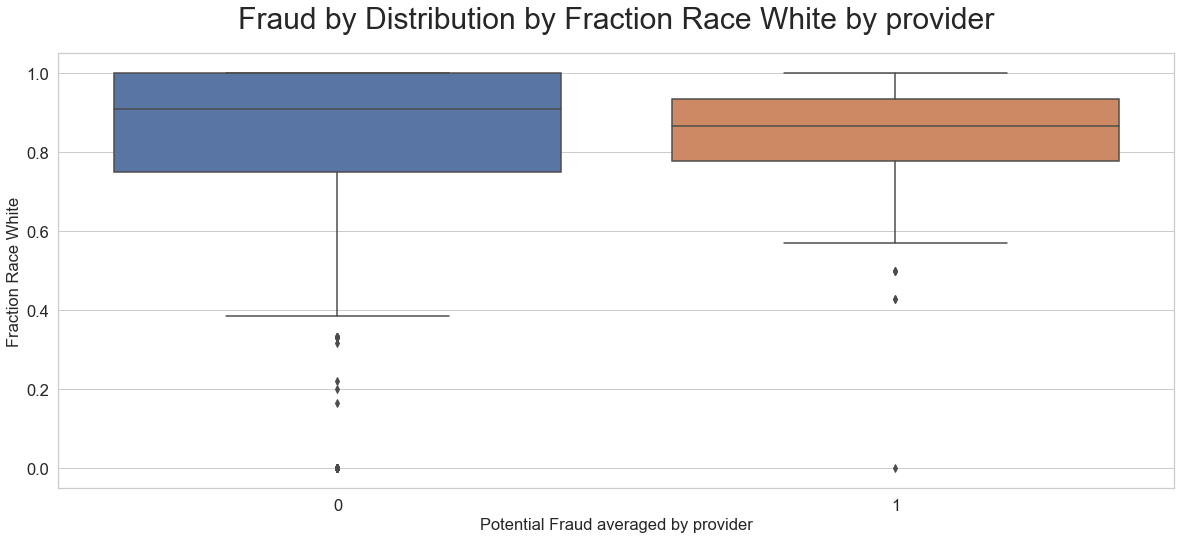

In [332]:
# Fraud by Distribution by Fraction Race White by provider
sns.boxplot(data=Imerge_race_pivot_ratio, x='PotentialFraud', y=Imerge_race_pivot_ratio[1])
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Fraction Race White by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Race White')
#plt.legend()

Text(0, 0.5, 'Fraction Race Non-White')

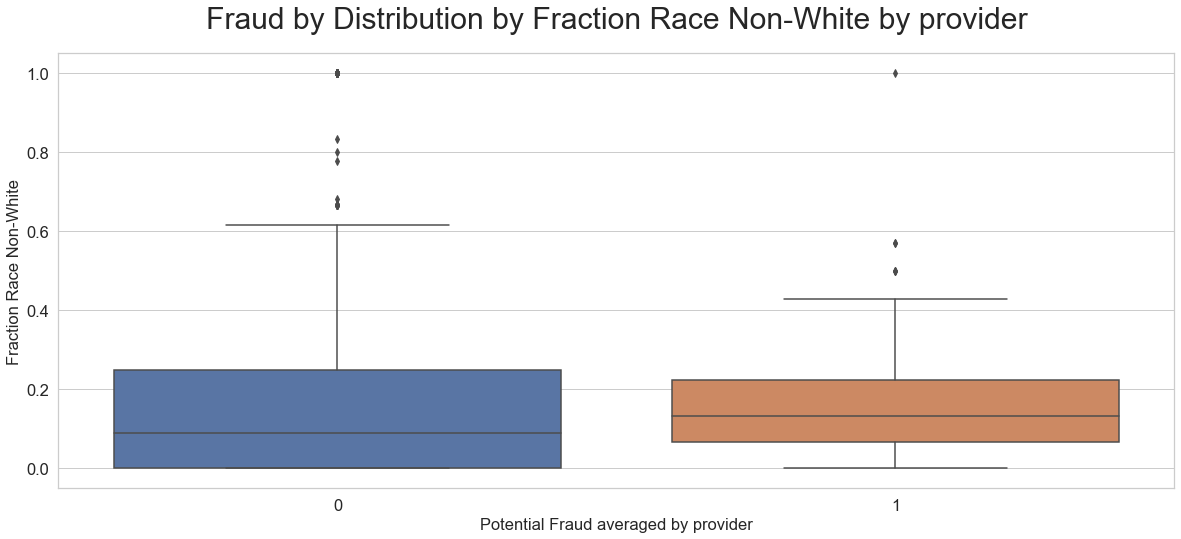

In [333]:
# Fraud by Distribution by Fraction Race Non-White by provider
sns.boxplot(data=Imerge_race_pivot_ratio, x='PotentialFraud', y='not_white')
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Fraction Race Non-White by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Race Non-White')
#plt.legend()

Text(0, 0.5, 'Fraction Race Black')

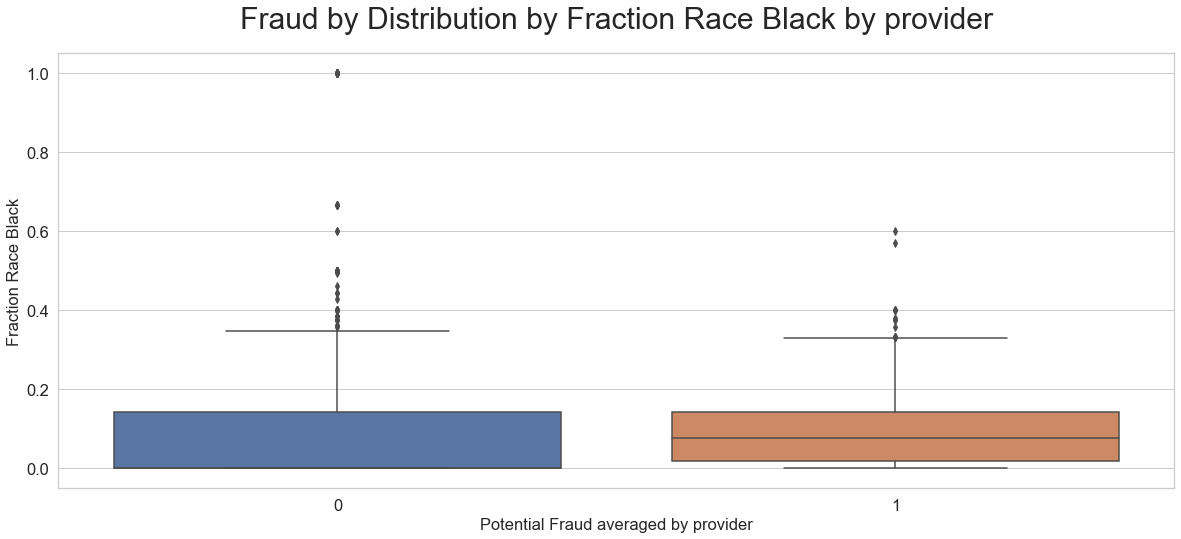

In [334]:
# Fraud by Distribution by Fraction Race Black by provider
sns.boxplot(data=Imerge_race_pivot_ratio, x='PotentialFraud', y=2)
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Fraction Race Black by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Race Black')
#plt.legend()

Text(0, 0.5, 'Fraction Race Other')

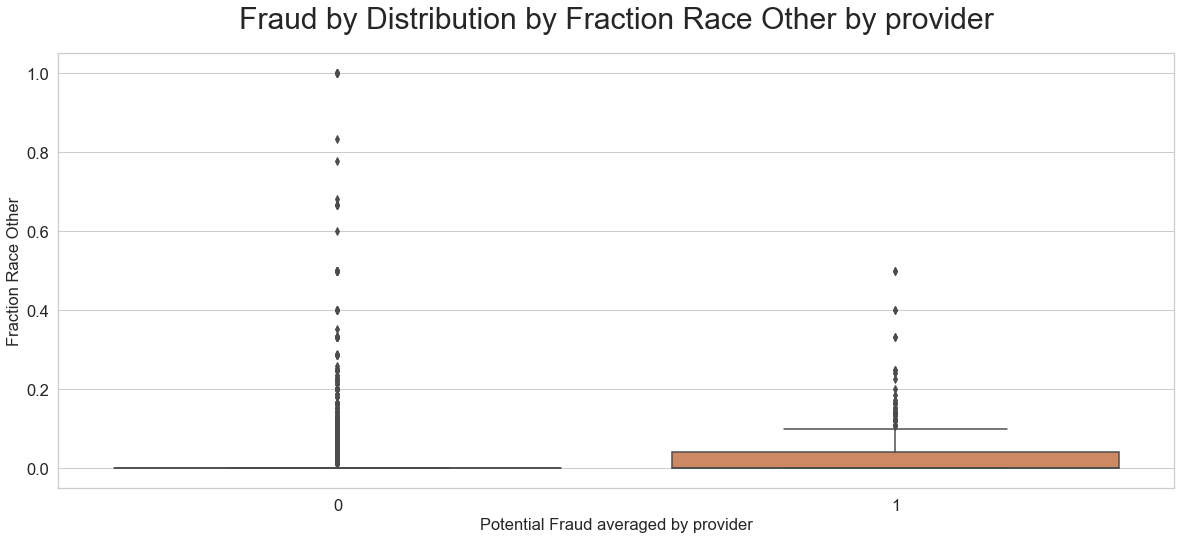

In [335]:
# Fraud by Distribution by Fraction Race Other by provider
sns.boxplot(data=Imerge_race_pivot_ratio, x='PotentialFraud', y=3)
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Fraction Race Other by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Race Other')
#plt.legend()

Text(0, 0.5, 'Fraction Race Hispanic')

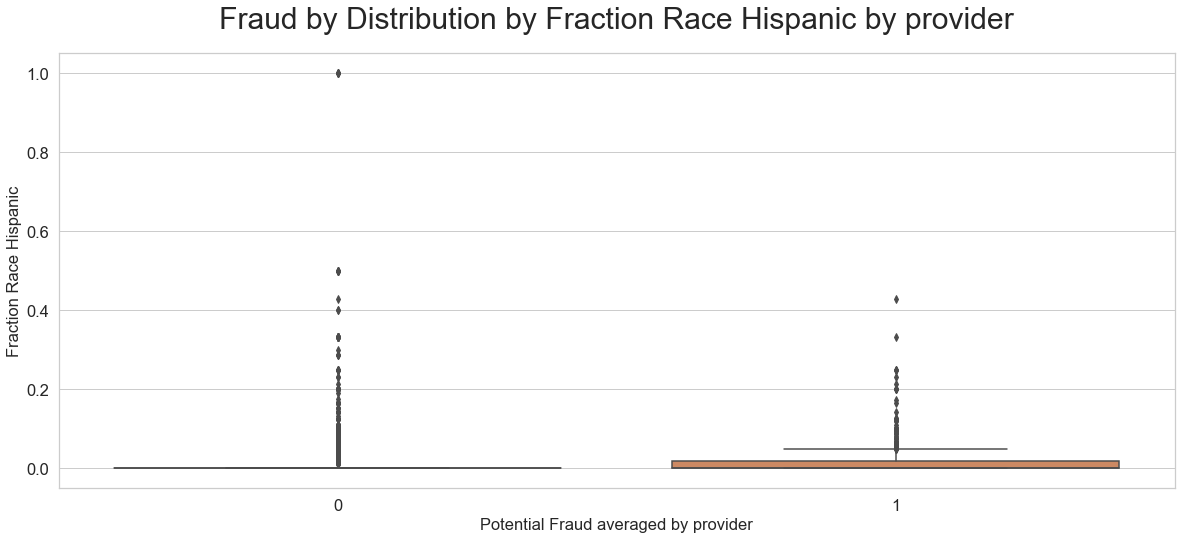

In [336]:
# Fraud by Distribution by Fraction Race Hispanic by provider
sns.boxplot(data=Imerge_race_pivot_ratio, x='PotentialFraud', y=5)
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Fraction Race Hispanic by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Race Hispanic')
#plt.legend()

Text(0, 0.5, 'Fraction Race Other+Hispanic')

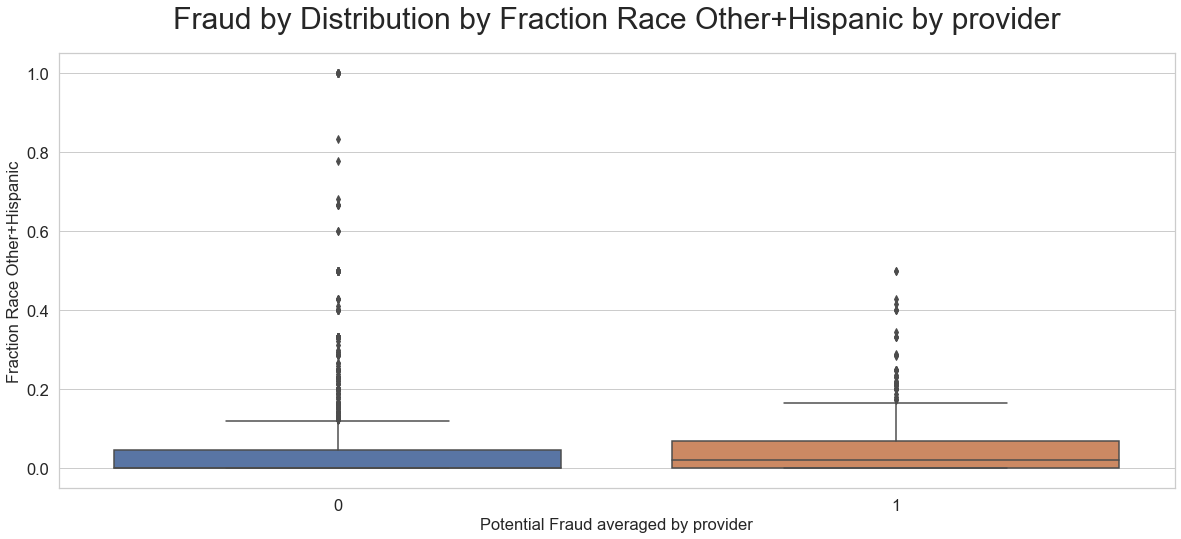

In [236]:
# Fraud by Distribution by Fraction Race Other+Hispanic by provider
sns.boxplot(data=Imerge_race_pivot_ratio, x='PotentialFraud', y='other_hispanic')
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Fraction Race Other+Hispanic by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Race Other+Hispanic')
#plt.legend()

## Sex/Gender 1 = MALE 2 = FEMALE
Useful graphic of sex structure: https://en.wikipedia.org/wiki/Demographics_of_the_United_States#/media/File:USA2020dec1.png

In [241]:
Imerge['Gender'].value_counts()

2    23267
1    17207
Name: Gender, dtype: int64

In [242]:
17207/23267

0.7395452787209352

In [245]:
Imerge_gender= Imerge.groupby(['Provider','PotentialFraud','Gender']).size().to_frame(name='size').reset_index()
Imerge_gender

,Provider,PotentialFraud,Gender,size
0,PRV51001,0,1,2
1,PRV51001,0,2,3
2,PRV51003,1,1,21
3,PRV51003,1,2,41
4,PRV51007,0,1,1
...,...,...,...,...
3758,PRV57729,0,2,4
3759,PRV57732,0,1,4
3760,PRV57732,0,2,7
3761,PRV57757,0,1,6


In [249]:
Imerge_gender_pivot= Imerge_gender.pivot_table(columns='Gender', index=['Provider', 'PotentialFraud'],values='size')
Imerge_gender_pivot

,Gender,1,2
Provider,PotentialFraud,,
PRV51001,0,2.0,3.0
PRV51003,1,21.0,41.0
PRV51007,0,1.0,2.0
PRV51008,0,1.0,1.0
PRV51011,0,NaN,1.0
...,...,...,...
PRV57719,0,3.0,1.0
PRV57728,0,1.0,NaN
PRV57729,0,7.0,4.0


In [257]:
Imerge_gender_pivot.reset_index(inplace=True)

In [262]:
Imerge_gender_pivot[1].values

array([ 2., 21.,  1., ...,  7.,  4.,  6.])

In [265]:
Imerge_gender_pivot['gender_ratio']=(Imerge_gender_pivot[1].values/Imerge_gender_pivot[2].values)
Imerge_gender_pivot.fillna(0, inplace = True)
Imerge_gender_pivot

Gender,Provider,PotentialFraud,1,2,gender_ratio
0,PRV51001,0,2.0,3.0,0.666667
1,PRV51003,1,21.0,41.0,0.512195
2,PRV51007,0,1.0,2.0,0.500000
3,PRV51008,0,1.0,1.0,1.000000
4,PRV51011,0,0.0,1.0,0.000000
...,...,...,...,...,...
2087,PRV57719,0,3.0,1.0,3.000000
2088,PRV57728,0,1.0,0.0,0.000000
2089,PRV57729,0,7.0,4.0,1.750000
2090,PRV57732,0,4.0,7.0,0.571429


Text(0, 0.5, 'Male/Female Gender Ratio')

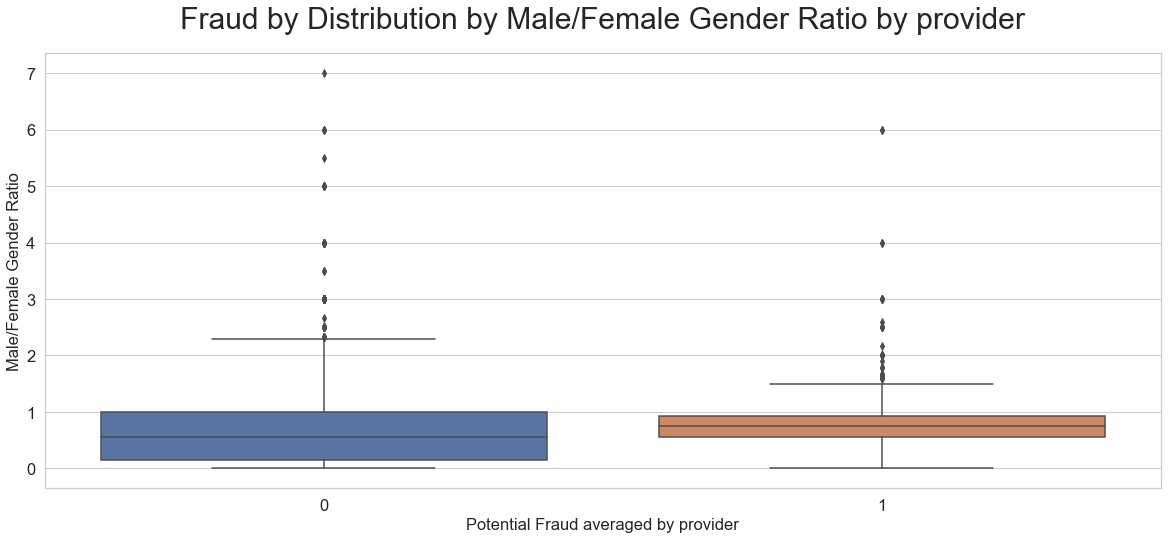

In [267]:
# Fraud by Distribution by Male/Female Gender Ratio by provider
sns.boxplot(data=Imerge_gender_pivot, x='PotentialFraud', y='gender_ratio')
#plt.ylim(6000,8000)
plt.title('Fraud by Distribution by Male/Female Gender Ratio by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Male/Female Gender Ratio')
#plt.legend()

## Fraction Deceased

In [271]:
Imerge['DOD'].value_counts()

0    40156
1      318
Name: DOD, dtype: int64

In [272]:
Imerge_DOD= Imerge.groupby(['Provider','PotentialFraud','DOD']).size().to_frame(name='size').reset_index()
Imerge_DOD

,Provider,PotentialFraud,DOD,size
0,PRV51001,0,0,5
1,PRV51003,1,0,61
2,PRV51003,1,1,1
3,PRV51007,0,0,3
4,PRV51008,0,0,2
...,...,...,...,...
2318,PRV57719,0,0,4
2319,PRV57728,0,0,1
2320,PRV57729,0,0,11
2321,PRV57732,0,0,11


In [343]:
Imerge_DOD_pivot= Imerge_DOD.pivot_table(columns='DOD', index=['Provider', 'PotentialFraud'],values='size')
Imerge_DOD_pivot.reset_index(inplace=True)
Imerge_DOD_pivot['sum_DOD']= Imerge_DOD_pivot.iloc[:,-2:].sum(1).values

In [344]:
Imerge_DOD_pivot

DOD,Provider,PotentialFraud,0,1,sum_DOD
0,PRV51001,0,5.0,NaN,5.0
1,PRV51003,1,61.0,1.0,62.0
2,PRV51007,0,3.0,NaN,3.0
3,PRV51008,0,2.0,NaN,2.0
4,PRV51011,0,1.0,NaN,1.0
...,...,...,...,...,...
2087,PRV57719,0,4.0,NaN,4.0
2088,PRV57728,0,1.0,NaN,1.0
2089,PRV57729,0,11.0,NaN,11.0
2090,PRV57732,0,11.0,NaN,11.0


In [274]:
Imerge_DOD_pivot.reset_index(inplace=True)

In [345]:
Imerge_DOD_pivot['fraction_died']=(Imerge_DOD_pivot[1].values/Imerge_DOD_pivot['sum_DOD'].values)
Imerge_DOD_pivot.fillna(0, inplace = True)
Imerge_DOD_pivot

DOD,Provider,PotentialFraud,0,1,sum_DOD,fraction_died
0,PRV51001,0,5.0,0.0,5.0,0.000000
1,PRV51003,1,61.0,1.0,62.0,0.016129
2,PRV51007,0,3.0,0.0,3.0,0.000000
3,PRV51008,0,2.0,0.0,2.0,0.000000
4,PRV51011,0,1.0,0.0,1.0,0.000000
...,...,...,...,...,...,...
2087,PRV57719,0,4.0,0.0,4.0,0.000000
2088,PRV57728,0,1.0,0.0,1.0,0.000000
2089,PRV57729,0,11.0,0.0,11.0,0.000000
2090,PRV57732,0,11.0,0.0,11.0,0.000000


In [363]:
pd.set_option('display.max_rows', None)
Imerge_DOD_pivot.sort_values(by='fraction_died', ascending=False)

DOD,Provider,PotentialFraud,0,1,sum_DOD,fraction_died
686,PRV52912,0,0.0,1.0,1.0,1.000000
1336,PRV55176,0,0.0,1.0,1.0,1.000000
860,PRV53511,0,0.0,1.0,1.0,1.000000
1112,PRV54543,1,1.0,2.0,3.0,0.666667
1077,PRV54384,0,1.0,1.0,2.0,0.500000
1553,PRV55942,0,1.0,1.0,2.0,0.500000
1606,PRV56135,0,2.0,1.0,3.0,0.333333
779,PRV53258,0,2.0,1.0,3.0,0.333333
126,PRV51311,0,2.0,1.0,3.0,0.333333
619,PRV52651,0,2.0,1.0,3.0,0.333333


Text(0, 0.5, 'Fraction Diseased')

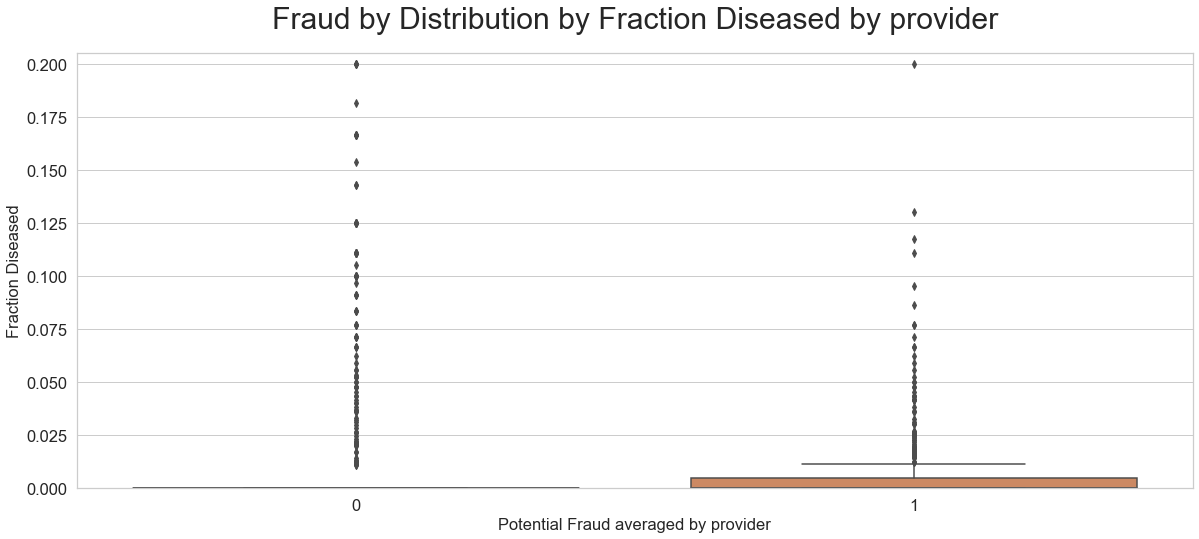

In [367]:
# Fraud by Distribution of Fraction Diseased by provider
sns.boxplot(data=Imerge_DOD_pivot, x='PotentialFraud', y='fraction_died')
plt.ylim(0,0.205)
plt.title('Fraud by Distribution by Fraction Diseased by provider')
plt.xlabel('Potential Fraud averaged by provider')
plt.ylabel('Fraction Diseased')
#plt.legend()

# Are physicians shared between providers?

## Attending Physicians: 128 attending physicians work at 2 or 3 providers

In [28]:
pd.set_option('display.max_rows', 100)
phy_drp=Imerge.groupby(['AttendingPhysician','PotentialFraud'])['Provider'].apply(pd.Series.nunique).to_frame(name='numUniqProv').reset_index()

In [29]:
pd.set_option('display.max_rows', None)
phy_drp_2 = phy_drp[phy_drp['numUniqProv']>1].sort_values(by='numUniqProv', ascending=False)
 # 128 attending physicians work at more than one provider

## operating Physicians: 63 work at 2 providers

In [31]:
phy_drp2=Imerge.groupby(['OperatingPhysician','PotentialFraud'])['Provider'].apply(pd.Series.nunique).to_frame(name='numUniqProv').reset_index()
phy_drp2_2 = phy_drp2[phy_drp2['numUniqProv']>1].sort_values(by='numUniqProv', ascending=False)

In [32]:
len(phy_drp2[phy_drp2['numUniqProv']>1].sort_values(by='numUniqProv', ascending=False))

63

## Other Physicians: 16 work at 2 or 3 providers

In [33]:
phy_drp3=Imerge.groupby(['OtherPhysician','PotentialFraud'])['Provider'].apply(pd.Series.nunique).to_frame(name='numUniqProv').reset_index()
phy_drp3_2=phy_drp3[phy_drp3['numUniqProv']>1].sort_values(by='numUniqProv', ascending=False)

In [34]:
len(phy_drp3[phy_drp3['numUniqProv']>1].sort_values(by='numUniqProv', ascending=False))

16

## Note that 530 (of 40474 total) physicans change between Attending, Operating and Other

In [35]:
att = Imerge['AttendingPhysician']
ope = Imerge['OperatingPhysician']
oth = Imerge['OtherPhysician']

In [36]:
len(att+ope+oth)

40474

In [37]:
len(list(set(att) & set(ope) & set(oth)))

530

## Number of physicians that work at more than one provider = 206, of which only 2 change between Att, Opr, Oth
21% of these attending physicians are associated with fraud providers, which is same percentage overall for fraud providers 440/2092
14% of these operating physicians are associated with fraud providers
31% of these other physicians are associated with fraud providers

In [38]:
att_2= phy_drp_2['AttendingPhysician']
ope_2= phy_drp2_2['OperatingPhysician']
oth_2= phy_drp3_2['OtherPhysician']

phy_list_2 =np.concatenate((att_2.values,ope_2.values,oth_2.values), axis=None)

list(set(att_2) & set(ope_2) & set(oth_2))

['PHY316039', 'PHY312782']

In [92]:
phy_list_2

array(['PHY395862', 'PHY311147', 'PHY312782', 'PHY405145', 'PHY403456',
       'PHY402792', 'PHY402515', 'PHY402409', 'PHY400645', 'PHY397753',
       'PHY397479', 'PHY396384', 'PHY395933', 'PHY395466', 'PHY393952',
       'PHY393744', 'PHY393208', 'PHY393110', 'PHY392961', 'PHY392736',
       'PHY392143', 'PHY391612', 'PHY390094', 'PHY389703', 'PHY388158',
       'PHY388128', 'PHY387333', 'PHY386998', 'PHY386600', 'PHY386022',
       'PHY383163', 'PHY406440', 'PHY407080', 'PHY407628', 'PHY425125',
       'PHY431514', 'PHY431267', 'PHY430902', 'PHY430864', 'PHY429493',
       'PHY429160', 'PHY429100', 'PHY429076', 'PHY428787', 'PHY428454',
       'PHY428158', 'PHY426323', 'PHY425449', 'PHY424815', 'PHY408872',
       'PHY424547', 'PHY424348', 'PHY423850', 'PHY423095', 'PHY421048',
       'PHY419839', 'PHY419129', 'PHY417126', 'PHY415913', 'PHY415385',
       'PHY414676', 'PHY413688', 'PHY411141', 'PHY380384', 'PHY380143',
       'PHY379756', 'PHY333112', 'PHY348314', 'PHY347916', 'PHY3

In [39]:
phy_list_2_att= Imerge[Imerge['AttendingPhysician'].isin(phy_list_2)]
phy_list_2_opr= Imerge[Imerge['OperatingPhysician'].isin(phy_list_2)]
phy_list_2_oth= Imerge[Imerge['OtherPhysician'].isin(phy_list_2)]

In [40]:
phy_list_2_att_fraud= phy_list_2_att.groupby(['Provider', 'PotentialFraud']).size().reset_index()

In [41]:
print(phy_list_2_att_fraud['PotentialFraud'].sum(0))
print(len(phy_list_2_att_fraud['PotentialFraud'])) # 39 potentially fraud out of 190 = 21%

39
190


In [42]:
39/190 # 21%

0.20526315789473684

In [43]:
440/2092 # 21% of inpatient providers are fraud

0.21032504780114722

In [44]:
phy_list_2_opr_fraud= phy_list_2_opr.groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(phy_list_2_opr_fraud['PotentialFraud'].sum(0))
print(len(phy_list_2_opr_fraud['PotentialFraud'])) # 17 potentially fraud out of 125 = 13.6%

17
125


In [45]:
17/125

0.136

In [46]:
phy_list_2_oth_fraud= phy_list_2_oth.groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(phy_list_2_oth_fraud['PotentialFraud'].sum(0))
print(len(phy_list_2_oth_fraud['PotentialFraud'])) # 16 potentially fraud out of 51 = 31%

16
51


In [47]:
16/51

0.3137254901960784

In [51]:
# 16 other physicians
phy_list_2_oth
# It turns out that there is one large fraudulent provider PRV52019 that always uses a particular Other physician PHY416093, thus inflating the percentage of fraudulent other physicians

,Provider,PotentialFraud,BeneID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,numChronic,Age,ClaimDuration,AdmitDays,numDiagCodes,numProcCodes,numPhysicians,ReimbPerDayAdmit
349,PRV51059,1,BENE142860,228,230,17000,PHY401443,PHY433877,PHY395466,228,5856,230,696,99664,2761,7100,0389,53081,2724,99591,5119,41401,138,598.0,NaN,NaN,NaN,NaN,0,2,1,1,1,160,12,12,0,1,1,0,0,0,0,1,0,0,0,17000,1068,2220,1580,3,83.0,2,2,10,1,3,8.495752e+03
351,PRV51059,1,BENE152088,18,23,39000,PHY381683,PHY392163,PHY395466,18,44101,23,249,4241,42821,78001,4240,5109,4280,51189,5119,4589,None,3523.0,5845.0,NaN,NaN,NaN,0,2,1,1,1,160,12,12,1,1,1,1,1,1,1,1,0,1,1,111710,4272,80,70,10,96.0,5,5,9,2,3,7.798440e+03
395,PRV51064,1,BENE133474,30,32,2000,PHY402515,None,PHY402515,30,4280,32,309,4280,4263,4254,41401,53081,V0481,42731,V1582,3970,None,NaN,NaN,NaN,NaN,NaN,0,2,1,0,1,130,12,12,0,1,1,0,0,0,1,1,0,1,0,5400,2136,1380,210,5,84.0,2,2,9,0,2,9.995002e+02
519,PRV51086,0,BENE49348,46,55,15000,PHY360985,PHY349768,PHY325656,46,4280,55,312,41071,5856,5990,5854,34831,2768,486,4254,72888,None,8856.0,NaN,NaN,NaN,NaN,0,1,1,1,1,80,12,12,1,1,1,0,0,1,0,1,0,0,0,15000,1068,220,200,5,86.0,9,9,9,1,3,1.666482e+03
529,PRV51086,0,BENE106291,294,297,30000,PHY369659,PHY369659,PHY369659,294,7384,297,479,7384,25000,311,7213,3051,412,None,None,None,None,8106.0,NaN,NaN,NaN,NaN,0,1,1,0,11,780,12,12,0,1,1,0,1,1,1,1,0,0,0,30000,1068,2310,610,6,75.0,3,3,6,1,3,9.996668e+03
539,PRV51086,0,BENE143869,87,93,14000,PHY347213,None,PHY349768,87,78060,93,867,0389,5601,79902,4019,20302,4264,4414,27903,5990,None,NaN,NaN,NaN,NaN,NaN,0,2,1,0,1,20,12,12,1,0,1,1,0,0,1,1,1,1,0,14000,1068,2210,1890,7,77.0,6,6,9,0,2,2.332945e+03
1551,PRV51165,0,BENE115324,230,232,14000,PHY418305,PHY367187,PHY367187,230,27651,232,845,20080,99673,5853,5180,7830,2639,V1581,1120,None,None,3893.0,NaN,NaN,NaN,NaN,0,1,1,0,5,400,12,12,0,1,1,0,1,0,1,1,1,1,0,14180,1068,1270,30,7,70.0,2,2,8,1,3,6.996502e+03
1670,PRV51207,0,BENE117262,90,125,38000,PHY422384,PHY422384,PHY422384,90,53250,125,332,53151,5070,261,5533,29580,7245,78559,E8888,5303,None,4439.0,NaN,NaN,NaN,NaN,0,1,3,1,3,10,12,12,1,1,1,1,1,1,1,1,1,0,1,129400,5340,180,50,10,70.0,35,35,9,1,3,1.085683e+03
1675,PRV51233,0,BENE57081,201,203,17000,PHY365519,PHY422384,PHY422384,201,78609,203,282,41071,41402,2875,4139,4142,53081,4111,49320,V854,None,66.0,2724.0,NaN,NaN,NaN,0,1,1,0,3,40,12,12,1,0,0,1,0,1,1,1,0,0,0,20020,2136,1600,120,5,74.0,2,2,9,2,3,8.495752e+03
5044,PRV51598,0,BENE24544,360,362,8000,PHY319437,PHY433796,PHY319437,360,185,362,708,185,41401,2724,25002,None,None,None,None,None,None,605.0,NaN,NaN,NaN,NaN,0,1,1,0,5,480,12,12,1,1,0,1,0,0,1,1,1,0,0,8000,1068,1530,80,6,69.0,2,2,4,1,3,3.998001e+03


## But maybe just having any Operating Physician or Other Physician is associated with fraud providers?
! not so, 21-22% of providers from claims having any of the three physician types are fraudulent, same frequency as overall !!

In [20]:
print(Imerge[Imerge['AttendingPhysician'].astype('str')!= 'None']) #40362 claims have an attending physician
att_phy_fraud = Imerge[Imerge['AttendingPhysician'].astype('str')!= 'None'].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(att_phy_fraud['PotentialFraud'].sum(0))
print(len(att_phy_fraud['PotentialFraud'])) # 440 potentially fraud out of 2089 = 21%

       Provider  PotentialFraud      BeneID  ClaimStartDt  ClaimEndDt  \
0      PRV51001               0   BENE36012           185         189   
1      PRV51001               0   BENE38773           143         145   
2      PRV51001               0   BENE98831            34          39   
3      PRV51001               0  BENE102690           124         138   
4      PRV51001               0  BENE152088            37          37   
...         ...             ...         ...           ...         ...   
40469  PRV57757               0  BENE108243            63          85   
40470  PRV57757               0  BENE114916            43          49   
40471  PRV57757               0  BENE123698            49          52   
40472  PRV57757               0  BENE139580           144         145   
40473  PRV57757               0  BENE140375           312         327   

       InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                       36000          PHY340163    

In [22]:
print(Imerge[Imerge['OperatingPhysician'].astype('str')!= 'None']) #23830 claims have an operating physician
opr_phy_fraud = Imerge[Imerge['OperatingPhysician'].astype('str')!= 'None'].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(opr_phy_fraud['PotentialFraud'].sum(0))
print(len(opr_phy_fraud['PotentialFraud'])) # 439 potentially fraud out of 1959 = 22%

       Provider  PotentialFraud      BeneID  ClaimStartDt  ClaimEndDt  \
3      PRV51001               0  BENE102690           124         138   
4      PRV51001               0  BENE152088            37          37   
5      PRV51003               1   BENE18650           133         139   
6      PRV51003               1   BENE21377            57          64   
7      PRV51003               1   BENE24383           100         106   
...         ...             ...         ...           ...         ...   
40466  PRV57757               0   BENE60146           187         188   
40467  PRV57757               0   BENE77790           287         291   
40469  PRV57757               0  BENE108243            63          85   
40471  PRV57757               0  BENE123698            49          52   
40473  PRV57757               0  BENE140375           312         327   

       InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
3                       42000          PHY383193    

In [23]:
439/1959

0.22409392547217968

In [16]:
# Imerge[Imerge['OtherPhysician'].astype('str')!= 'None'] #4690 claims have an other physician
oth_phy_fraud = Imerge[Imerge['OtherPhysician'].astype('str')!= 'None'].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(oth_phy_fraud['PotentialFraud'].sum(0))
print(len(oth_phy_fraud['PotentialFraud'])) # 279 potentially fraud out of 1157 = 24%

279
1157


In [17]:
279/1157

0.2411408815903198

## Conclusions for analysis of physicians: 
For physicians that work at more than one clinic: 
* 21% of these attending physicians are associated with fraud providers, which is same percentage overall for fraud providers 440/2092 
* 14% of these operating physicians are associated with fraud providers 
* 31% of these other physicians are associated with fraud providers
* BUT, it turns out that there is one large fraudulent provider PRV52019 that always uses a particular Other physician PHY416093, thus inflating the percentage of fraudulent other physicians, thus there is likely no clear correlation between physicians and fraud

# Relationship of Fraud and Beneficiary Age 

<AxesSubplot:xlabel='Age', ylabel='Count'>

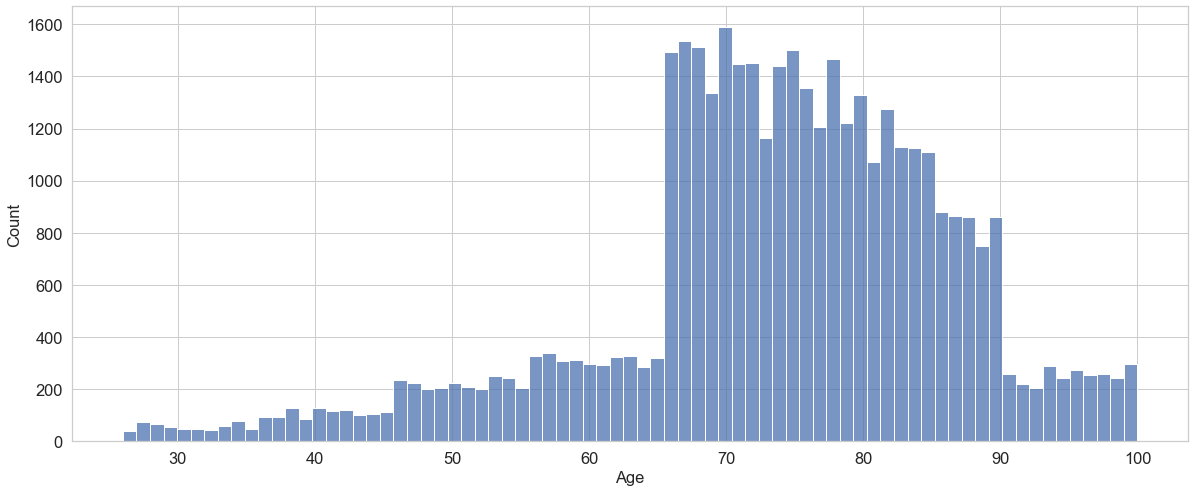

In [66]:
sns.histplot(data=Imerge['Age'], bins=75)

<AxesSubplot:xlabel='Age', ylabel='Count'>

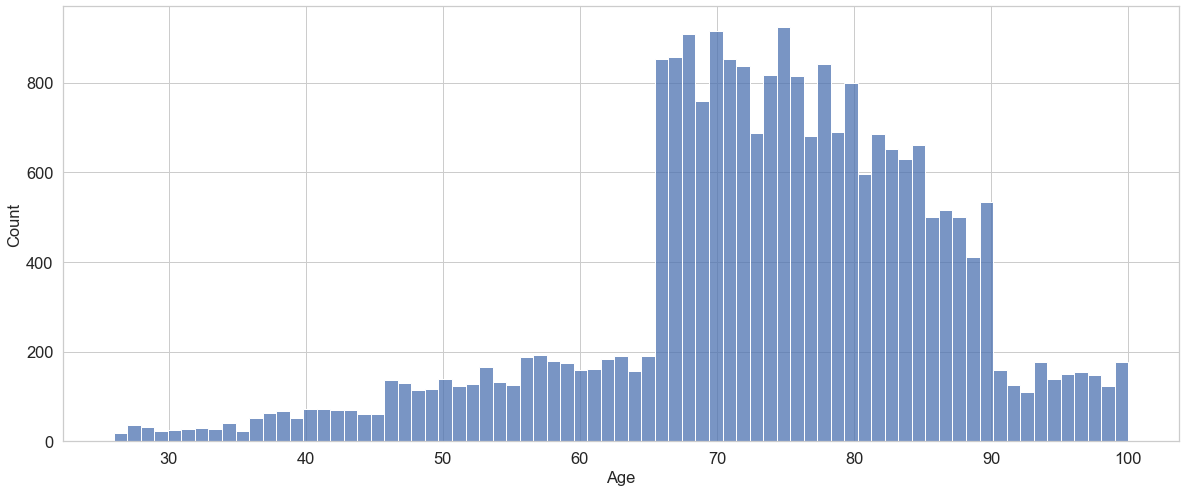

In [67]:
sns.histplot(data=Imerge[Imerge['PotentialFraud']==1]['Age'], bins=75)

In [25]:
# percent fraud for ages <31
age30=Imerge[(Imerge['Age']<31)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age30['PotentialFraud'].sum(0))
print(len(age30['PotentialFraud']))
print(age30['PotentialFraud'].sum(0)/len(age30['PotentialFraud'])) # 44% fraud

97
217
0.4470046082949309


In [21]:
# percent fraud for ages 31-40
age3140=Imerge[(Imerge['Age']>30) & (Imerge['Age']<=40)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age3140['PotentialFraud'].sum(0))
print(len(age3140['PotentialFraud']))
print(age3140['PotentialFraud'].sum(0)/len(age3140['PotentialFraud'])) # 42% fraud

198
466
0.4248927038626609


In [20]:
# percent fraud for ages 41-50
age4150=Imerge[(Imerge['Age']>40) & (Imerge['Age']<=50)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age4150['PotentialFraud'].sum(0))
print(len(age4150['PotentialFraud']))
print(age4150['PotentialFraud'].sum(0)/len(age4150['PotentialFraud'])) # 38% fraud

285
744
0.38306451612903225


In [19]:
# percent fraud for ages 51-60
age5160=Imerge[(Imerge['Age']>50) & (Imerge['Age']<=60)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age5160['PotentialFraud'].sum(0))
print(len(age5160['PotentialFraud']))
print(age5160['PotentialFraud'].sum(0)/len(age5160['PotentialFraud'])) # 34% fraud

321
948
0.33860759493670883


In [18]:
# percent fraud for ages 61-70
age6170=Imerge[(Imerge['Age']>60) & (Imerge['Age']<=70)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age6170['PotentialFraud'].sum(0))
print(len(age6170['PotentialFraud']))
print(age6170['PotentialFraud'].sum(0)/len(age6170['PotentialFraud'])) # 26% fraud

406
1545
0.2627831715210356


In [17]:
# percent fraud for ages 71-80
age7180=Imerge[(Imerge['Age']>70) & (Imerge['Age']<=80)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age7180['PotentialFraud'].sum(0))
print(len(age7180['PotentialFraud']))
print(age7180['PotentialFraud'].sum(0)/len(age7180['PotentialFraud'])) # 25% fraud

429
1717
0.24985439720442632


In [22]:
# percent fraud for ages 81-90
age8190=Imerge[(Imerge['Age']>80) & (Imerge['Age']<=90)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age8190['PotentialFraud'].sum(0))
print(len(age8190['PotentialFraud']))
print(age8190['PotentialFraud'].sum(0)/len(age8190['PotentialFraud'])) # 25% fraud

418
1615
0.25882352941176473


In [24]:
# percent fraud for ages 91-100
age91100=Imerge[(Imerge['Age']>91) & (Imerge['Age']<=100)].groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age91100['PotentialFraud'].sum(0))
print(len(age91100['PotentialFraud']))
print(age91100['PotentialFraud'].sum(0)/len(age91100['PotentialFraud'])) # 35% fraud

306
871
0.3513203214695752


In [16]:
age_all=Imerge.groupby(['Provider', 'PotentialFraud']).size().reset_index()
print(age_all['PotentialFraud'].sum(0))
print(len(age_all['PotentialFraud']))
print(age_all['PotentialFraud'].sum(0)/len(age_all['PotentialFraud'])) # 21% fraud

440
2092
0.21032504780114722


In [30]:
all_age_F=Imerge[Imerge['PotentialFraud']==1].groupby(['Provider', 'PotentialFraud'])['Age'].mean().reset_index()

In [31]:
all_age_F['Age'].mean()

73.5800047032628

In [33]:
all_age=Imerge[Imerge['PotentialFraud']==0].groupby(['Provider', 'PotentialFraud'])['Age'].mean().reset_index()
all_age['Age'].mean()

73.61273336320538

# Feature engineering of Imerge dataframe

In [163]:
# function to create dataframe summarizing provider information by rows with engineered features

from collections import Counter

def make_df(in_df, out_df, **columns):
    '''
    function to create dataframe with engineered features
    args
    in_df: base dataframe
    out_df: output dataframe name string
    columns: kwargs of column names to apply summary statistics
    
    '''
    no_std_cols= ['DOD', 'Gender', 'Race','RenalDiseaseIndicator',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke' ]
    
    # Potential fraud column
    potentialFraud_df = in_df.groupby(['Provider','PotentialFraud'])
    out_df = pd.DataFrame(potentialFraud_df.apply(lambda x: x.name)).reset_index().drop(columns=[0])
    
    # Number unique beneficiaries per provider
    numBene_df = in_df.groupby(['Provider'])['BeneID'].apply(pd.Series.nunique).to_frame(name='numBene').reset_index()
    out_df = out_df.merge(numBene_df, on='Provider')
    
    # Number unique claims per provider
    numClaim_df = Imerge.groupby(['Provider'])['BeneID'].count().to_frame(name='numClaim').reset_index()
    out_df = out_df.merge(numClaim_df, on='Provider')
    
    # Sum reimbursments per provider
    reimb_df = Imerge.groupby(['Provider'])['InscClaimAmtReimbursed'].sum().to_frame(name='InscClaimAmtReimbursed_sum').reset_index()
    out_df = out_df.merge(reimb_df, on='Provider')
    
    # Number unique counties per provider
    numCo_df = Imerge.groupby(['Provider'])[['County']].agg(pd.Series.nunique).reset_index()
    out_df = out_df.merge(numCo_df, on='Provider')

    # Summary statistics for column names given in kwargs
    for key, value in columns.items():
        if in_df[key].dtypes !='O':
            print(key)
            if key in no_std_cols:
                grp_agg = in_df.groupby(['Provider'])[[value]].agg([(key+'_mean', 'mean')]).reset_index().droplevel(1, axis='columns')
                out_df = out_df.merge(grp_agg, on='Provider')
                out_df.columns.values[-2:] = (key+'_mean') 
            else:
                grp_agg = in_df.groupby(['Provider'])[[value]].agg([(key+'_mean', 'mean'), (key+'_mad', 'mad')]).reset_index().droplevel(1, axis='columns')
                out_df = out_df.merge(grp_agg, on='Provider')
                out_df.columns.values[-2:] = (key+'_mean', key+'_mad')
    
    # Number Unique Admit and Group codes used by providers
    adm_grp_code_cols= ['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']
    for col in adm_grp_code_cols:
        grp_agg = in_df.groupby(['Provider'])[col].apply(pd.Series.nunique).to_frame(name='_uniq').reset_index()
        out_df = out_df.merge(grp_agg, on='Provider')
        out_df.columns.values[-1:] = col+'_uniq'
        
    # Number Unique Diag codes used by providers
    diagConcat = pd.concat([Imerge['ClmDiagnosisCode_1'],Imerge['ClmDiagnosisCode_2'],Imerge['ClmDiagnosisCode_3'],
                 Imerge['ClmDiagnosisCode_4'],Imerge['ClmDiagnosisCode_5'],
                 Imerge['ClmDiagnosisCode_6'],Imerge['ClmDiagnosisCode_7'],Imerge['ClmDiagnosisCode_8'],
                 Imerge['ClmDiagnosisCode_9'],Imerge['ClmDiagnosisCode_10']], ignore_index=True, sort=False)

    provConcat = pd.concat([Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],
                Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider']], ignore_index=True, sort=False)

    diag_provConcat = pd.concat([diagConcat, provConcat], axis=1)

    grp_agg = diag_provConcat.groupby(['Provider'])[0].apply(pd.Series.nunique).to_frame(name='_uniq').reset_index()
    out_df = out_df.merge(grp_agg, on='Provider')
    out_df.columns.values[-1:] = 'ClmDiagnosisCodes_uniq'   
        
    # Number Unique Proc codes used by providers
    procConcat = pd.concat([Imerge['ClmProcedureCode_1'],Imerge['ClmProcedureCode_2'],Imerge['ClmProcedureCode_3'],
                 Imerge['ClmProcedureCode_4'],Imerge['ClmProcedureCode_5']], ignore_index=True, sort=False)

    provConcat = pd.concat([Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],Imerge['Provider'],
                            Imerge['Provider']], ignore_index=True, sort=False)

    proc_provConcat = pd.concat([procConcat, provConcat], axis=1)

    grp_agg = proc_provConcat.groupby(['Provider'])[0].apply(pd.Series.nunique).to_frame(name='_uniq').reset_index()
    out_df = out_df.merge(grp_agg, on='Provider')
    out_df.columns.values[-1:] = 'ClmProcedureCodes_uniq'             
        
    return out_df   


In [152]:
Imerge.dtypes

Provider                            object
PotentialFraud                       int64
BeneID                              object
ClaimStartDt                         int64
ClaimEndDt                           int64
InscClaimAmtReimbursed               int64
AttendingPhysician                  object
OperatingPhysician                  object
OtherPhysician                      object
AdmissionDt                          int64
ClmAdmitDiagnosisCode               object
DischargeDt                          int64
DiagnosisGroupCode                  object
ClmDiagnosisCode_1                  object
ClmDiagnosisCode_2                  object
ClmDiagnosisCode_3                  object
ClmDiagnosisCode_4                  object
ClmDiagnosisCode_5                  object
ClmDiagnosisCode_6                  object
ClmDiagnosisCode_7                  object
ClmDiagnosisCode_8                  object
ClmDiagnosisCode_9                  object
ClmDiagnosisCode_10                 object
ClmProcedur

In [35]:
# convert integer procedure code columns to type object to calculate mode
# ccols=['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure',
#        'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
#        'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart',
#        'ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke']
# cols2obj=['ClmProcedureCode_1',
#        'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
#        'ClmProcedureCode_5','DOD','State','County']

# Imerge[cols2obj]= Imerge[cols2obj].astype('object')

In [162]:
useful_cols= [
       'InscClaimAmtReimbursed','ReimbPerDayAdmit', 'ClaimStartDt','AdmissionDt', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'numChronic', 'Age', 'ClaimDuration',
       'AdmitDays', 'numPhysicians', 'numDiagCodes', 'numProcCodes' ]
useful_cols_dict = {i: i for i in Imerge[useful_cols].columns}

no_std_cols= ['DOD', 'Gender', 'Race','RenalDiseaseIndicator',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke' ]
#no_std_cols_dict = {i: i for i in Imerge[no_std_cols].columns}

In [164]:
trIeng_df = make_df(Imerge, 'out_df', **useful_cols_dict)

InscClaimAmtReimbursed
ReimbPerDayAdmit
ClaimStartDt
AdmissionDt
DOD
Gender
Race
RenalDiseaseIndicator
NoOfMonths_PartACov
NoOfMonths_PartBCov
ChronicCond_Alzheimer
ChronicCond_Heartfailure
ChronicCond_KidneyDisease
ChronicCond_Cancer
ChronicCond_ObstrPulmonary
ChronicCond_Depression
ChronicCond_Diabetes
ChronicCond_IschemicHeart
ChronicCond_Osteoporasis
ChronicCond_rheumatoidarthritis
ChronicCond_stroke
IPAnnualReimbursementAmt
IPAnnualDeductibleAmt
numChronic
Age
ClaimDuration
AdmitDays
numPhysicians
numDiagCodes
numProcCodes


In [165]:
trIeng_df

,Provider,PotentialFraud,numBene,numClaim,InscClaimAmtReimbursed_sum,County,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_mad,ReimbPerDayAdmit_mean,ReimbPerDayAdmit_mad,ClaimStartDt_mean,ClaimStartDt_mad,AdmissionDt_mean,DOD_mean,Gender_mean,Race_mean,RenalDiseaseIndicator_mean,NoOfMonths_PartACov_mean,NoOfMonths_PartBCov_mean,ChronicCond_Alzheimer_mean,ChronicCond_Heartfailure_mean,ChronicCond_KidneyDisease_mean,ChronicCond_Cancer_mean,ChronicCond_ObstrPulmonary_mean,ChronicCond_Depression_mean,ChronicCond_Diabetes_mean,ChronicCond_IschemicHeart_mean,ChronicCond_Osteoporasis_mean,ChronicCond_rheumatoidarthritis_mean,ChronicCond_stroke_mean,ChronicCond_stroke_mean,IPAnnualReimbursementAmt_mean,IPAnnualReimbursementAmt_mad,IPAnnualDeductibleAmt_mean,IPAnnualDeductibleAmt_mad,numChronic_mean,numChronic_mad,Age_mean,Age_mad,ClaimDuration_mean,ClaimDuration_mad,AdmitDays_mean,AdmitDays_mad,numPhysicians_mean,numPhysicians_mad,numDiagCodes_mean,numDiagCodes_mad,numProcCodes_mean,numProcCodes_mad,ClmAdmitDiagnosisCode_uniq,DiagnosisGroupCode_uniq,ClmDiagnosisCodes_uniq,ClmProcedureCodes_uniq
0,PRV51001,0,5,5,97000,2,19400.000000,15680.000000,803718.400000,1.278513e+06,104.600000,55.280000,104.600000,55.280000,0.000000,0.400000,1.000000,0.400000,12.000000,12.000000,0.400000,0.800000,0.800000,0.200000,0.400000,0.800000,0.800000,0.800000,0.000000,0.600000,0.400000,77902.000000,46721.600000,2563.200000,1367.040000,6.000000,2.000000,78.200000,7.840000,5.000000,3.600000,5.000000,3.600000,1.600000,0.720000,7.200000,1.040000,0.600000,0.720000,5,5,34,3
1,PRV51003,1,53,62,573000,13,9241.935484,5143.080125,3329.241935,2.887682e+03,163.758065,90.016129,163.758065,90.016129,0.016129,0.338710,0.790323,0.274194,11.806452,11.806452,0.516129,0.580645,0.629032,0.112903,0.370968,0.403226,0.790323,0.887097,0.209677,0.306452,0.112903,12696.612903,6963.267430,1604.064516,706.926119,4.919355,1.832986,70.387097,11.602497,5.161290,3.046826,5.161290,3.046826,1.645161,0.457856,8.112903,1.388137,0.774194,0.574402,46,58,271,39
2,PRV51007,0,3,3,19000,1,6333.333333,2444.444444,1308.666667,5.871111e+02,151.000000,53.333333,151.000000,53.333333,0.000000,0.333333,1.000000,0.333333,12.000000,12.000000,0.666667,1.000000,0.333333,0.000000,0.000000,0.666667,1.000000,1.000000,0.000000,0.333333,0.666667,11710.000000,3726.666667,2136.000000,712.000000,5.666667,0.444444,78.333333,3.555556,5.333333,1.111111,5.333333,1.111111,1.333333,0.444444,7.333333,1.111111,0.333333,0.444444,3,3,22,1
3,PRV51008,0,2,2,25000,1,12500.000000,8500.000000,3898.000000,3.099000e+03,138.500000,29.500000,138.500000,29.500000,0.000000,0.500000,1.000000,0.000000,12.000000,12.000000,0.500000,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,18750.000000,14750.000000,1602.000000,534.000000,3.500000,0.500000,51.000000,22.000000,4.000000,1.000000,4.000000,1.000000,2.000000,0.000000,7.500000,1.500000,1.000000,0.000000,2,2,15,2
4,PRV51011,0,1,1,5000,1,5000.000000,0.000000,999.000000,0.000000e+00,295.000000,0.000000,295.000000,0.000000,0.000000,0.000000,1.000000,1.000000,12.000000,12.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5000.000000,0.000000,1068.000000,0.000000,7.000000,0.000000,97.000000,0.000000,5.000000,0.000000,5.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,PRV57719,0,4,4,76000,3,19000.000000,19000.000000,2130.250000,1.432375e+03,161.000000,64.000000,161.000000,64.000000,0.000000,0.750000,1.000000,0.250000,12.000000,12.000000,0.750000,1.000000,0.500000,0.250000,0.500000,0.750000,1.000000,0.750000,1.000000,0.500000,0.250000,25210.000000,19210.000000,2352.000000,1284.000000,7.250000,0.750000,65.500000,14.750000,13.750000,10.750000,13.750000,10.

In [166]:
trIeng_df.dtypes

Provider                                 object
PotentialFraud                            int64
numBene                                   int64
numClaim                                  int64
InscClaimAmtReimbursed_sum                int64
County                                    int64
InscClaimAmtReimbursed_mean             float64
InscClaimAmtReimbursed_mad              float64
ReimbPerDayAdmit_mean                   float64
ReimbPerDayAdmit_mad                    float64
ClaimStartDt_mean                       float64
ClaimStartDt_mad                        float64
AdmissionDt_mean                        float64
DOD_mean                                float64
Gender_mean                             float64
Race_mean                               float64
RenalDiseaseIndicator_mean              float64
NoOfMonths_PartACov_mean                float64
NoOfMonths_PartBCov_mean                float64
ChronicCond_Alzheimer_mean              float64
ChronicCond_Heartfailure_mean           

In [175]:
trIeng_df['Gender_mean'].value_counts()

0.000000    1858
0.111111       9
0.125000       7
0.100000       6
0.047619       6
0.066667       5
0.076923       5
0.071429       5
0.333333       5
0.200000       5
0.043478       5
0.166667       5
0.052632       4
0.026316       4
0.041667       4
0.050000       4
0.012346       4
0.250000       4
0.090909       3
0.017241       3
0.083333       3
0.055556       3
0.020000       3
0.025641       3
1.000000       3
0.024390       3
0.036585       2
0.025000       2
0.030303       2
0.040000       2
0.010638       2
0.058824       2
0.016129       2
0.019231       2
0.062500       2
0.045455       2
0.015625       2
0.031250       2
0.020833       2
0.006211       2
0.038462       2
0.500000       2
0.021739       2
0.035714       2
0.037037       2
0.142857       2
0.012195       2
0.053571       1
0.017778       1
0.026786       1
0.017143       1
0.042254       1
0.017857       1
0.014493       1
0.016393       1
0.005917       1
0.011628       1
0.004673       1
0.029851      

In [401]:
# something strange with the last column being type float64, change to int64
trIeng_df['ClmProcedureCodes_uniq']= trIeng_df['ClmProcedureCodes_uniq'].astype("int64")

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [390]:
trIeng_df.to_pickle("./data/trIeng_df.pkl")

In [402]:
trIeng_df=pd.read_pickle("./data/trIeng_df.pkl")

In [415]:
trIeng_df.dtypes

PotentialFraud                            int64
numBene                                   int64
numClaim                                  int64
InscClaimAmtReimbursed_sum                int64
InscClaimAmtReimbursed_mean             float64
InscClaimAmtReimbursed_mad              float64
ReimbPerDayAdmit_mean                   float64
ReimbPerDayAdmit_mad                    float64
AttendingPhysician_mode                  object
OperatingPhysician_mode                  object
OtherPhysician_mode                      object
ClaimStartDt_mean                       float64
ClaimStartDt_mad                        float64
AdmissionDt_mean                        float64
AdmissionDt_mad                         float64
ClmAdmitDiagnosisCode_mode               object
DiagnosisGroupCode_mode                  object
ClmDiagnosisCode_1_mode                  object
ClmDiagnosisCode_2_mode                  object
ClmDiagnosisCode_3_mode                  object
ClmDiagnosisCode_4_mode                 

In [407]:
# convert columns to object type: ClmProcedureCode_1_mode, etc.

proc_m=['ClmProcedureCode_1_mode',
'ClmProcedureCode_2_mode',
'ClmProcedureCode_3_mode', 
'ClmProcedureCode_4_mode',
'ClmProcedureCode_5_mode']

trIeng_df[proc_m]= trIeng_df[proc_m].astype("object")

In [413]:
trIeng_df['ClmProcedureCode_5_mode'].fillna('None', inplace=True)

In [414]:
trIeng_df.drop(['Provider'], inplace=True, axis=1)

# One Hot and Label Encoding of trIeng_df dataframe

In [417]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

trIeng_df_obj = trIeng_df.select_dtypes(["object"])
trIeng_df_obj = trIeng_df_obj.astype('str')
trIeng_df_num = trIeng_df.select_dtypes(["float64","int64"])

#OneHotEncoder function to dummify
ohe = OneHotEncoder(categories = "auto",drop = 'first' ,sparse = False)
trIeng_df_ohe = ohe.fit_transform(trIeng_df_obj)
column = ohe.get_feature_names(trIeng_df_obj.columns.tolist())

#LabelEncoder function to encode undummified version
le = LabelEncoder()
trIeng_df_le = trIeng_df_obj.apply(le.fit_transform, axis = 0)
column_le = trIeng_df_obj.columns.tolist()

In [418]:
# Combine the object and numeric features back again for dummified train df
trIeng_df_du_ =  pd.DataFrame(trIeng_df_ohe, columns= column)
trIeng_df_du_.set_index(trIeng_df_num.index, inplace = True)
trIeng_df_dum = pd.concat([trIeng_df_du_, trIeng_df_num], axis = 1)

# same, but for undummified version of df
trIeng_df_un_ =  pd.DataFrame(trIeng_df_le, columns= column_le)
trIeng_df_un_.set_index(trIeng_df_num.index, inplace = True)
trIeng_df_undum = pd.concat([trIeng_df_un_, trIeng_df_num], axis = 1)

In [419]:
trIeng_df_dum

,AttendingPhysician_mode_PHY311207,AttendingPhysician_mode_PHY311262,AttendingPhysician_mode_PHY311276,AttendingPhysician_mode_PHY311435,AttendingPhysician_mode_PHY311447,AttendingPhysician_mode_PHY311461,AttendingPhysician_mode_PHY311470,AttendingPhysician_mode_PHY311527,AttendingPhysician_mode_PHY311763,AttendingPhysician_mode_PHY311773,AttendingPhysician_mode_PHY311791,AttendingPhysician_mode_PHY312045,AttendingPhysician_mode_PHY312090,AttendingPhysician_mode_PHY312104,AttendingPhysician_mode_PHY312106,AttendingPhysician_mode_PHY312240,AttendingPhysician_mode_PHY312289,AttendingPhysician_mode_PHY312430,AttendingPhysician_mode_PHY312495,AttendingPhysician_mode_PHY312514,AttendingPhysician_mode_PHY312620,AttendingPhysician_mode_PHY312631,AttendingPhysician_mode_PHY312648,AttendingPhysician_mode_PHY312690,AttendingPhysician_mode_PHY312694,AttendingPhysician_mode_PHY312731,AttendingPhysician_mode_PHY312782,AttendingPhysician_mode_PHY312969,AttendingPhysician_mode_PHY313137,AttendingPhysician_mode_PHY313145,AttendingPhysician_mode_PHY313202,AttendingPhysician_mode_PHY313234,AttendingPhysician_mode_PHY313286,AttendingPhysician_mode_PHY313291,AttendingPhysician_mode_PHY313321,AttendingPhysician_mode_PHY313358,AttendingPhysician_mode_PHY313453,AttendingPhysician_mode_PHY313508,AttendingPhysician_mode_PHY313528,AttendingPhysician_mode_PHY313867,AttendingPhysician_mode_PHY313904,AttendingPhysician_mode_PHY314092,AttendingPhysician_mode_PHY314143,AttendingPhysician_mode_PHY314263,AttendingPhysician_mode_PHY314346,AttendingPhysician_mode_PHY314364,AttendingPhysician_mode_PHY314379,AttendingPhysician_mode_PHY314410,AttendingPhysician_mode_PHY314420,AttendingPhysician_mode_PHY314614,AttendingPhysician_mode_PHY314635,AttendingPhysician_mode_PHY314636,AttendingPhysician_mode_PHY314687,AttendingPhysician_mode_PHY314739,AttendingPhysician_mode_PHY314803,AttendingPhysician_mode_PHY315082,AttendingPhysician_mode_PHY315112,AttendingPhysician_mode_PHY315125,AttendingPhysician_mode_PHY315129,AttendingPhysician_mode_PHY315138,AttendingPhysician_mode_PHY315180,AttendingPhysician_mode_PHY315192,AttendingPhysician_mode_PHY315243,AttendingPhysician_mode_PHY315310,AttendingPhysician_mode_PHY315331,AttendingPhysician_mode_PHY315388,AttendingPhysician_mode_PHY315400,AttendingPhysician_mode_PHY315427,AttendingPhysician_mode_PHY315561,AttendingPhysician_mode_PHY315642,AttendingPhysician_mode_PHY315666,AttendingPhysician_mode_PHY315701,AttendingPhysician_mode_PHY315735,AttendingPhysician_mode_PHY315746,AttendingPhysician_mode_PHY315799,AttendingPhysician_mode_PHY315820,AttendingPhysician_mode_PHY315916,AttendingPhysician_mode_PHY315962,AttendingPhysician_mode_PHY315991,AttendingPhysician_mode_PHY316039,AttendingPhysician_mode_PHY316064,AttendingPhysician_mode_PHY316075,AttendingPhysician_mode_PHY316222,AttendingPhysician_mode_PHY316253,AttendingPhysician_mode_PHY316254,AttendingPhysician_mode_PHY316310,AttendingPhysician_mode_PHY316432,AttendingPhysician_mode_PHY316444,AttendingPhysician_mode_PHY316445,AttendingPhysician_mode_PHY316512,AttendingPhysician_mode_PHY316573,AttendingPhysician_mode_PHY316613,AttendingPhysician_mode_PHY316615,AttendingPhysician_mode_PHY316628,AttendingPhysician_mode_PHY316641,AttendingPhysician_mode_PHY316707,AttendingPhysician_mode_PHY316732,AttendingPhysician_mode_PHY316772,AttendingPhysician_mode_PHY316775,AttendingPhysician_mode_PHY316844,AttendingPhysician_mode_PHY316969,AttendingPhysician_mode_PHY317038,AttendingPhysician_mode_PHY317073,AttendingPhysician_mode_PHY317127,AttendingPhysician_mode_PHY317130,AttendingPhysician_mode_PHY317208,AttendingPhysician_mode_PHY317211,AttendingPhysician_mode_PHY317316,AttendingPhysician_mode_PHY317363,AttendingPhysician_mode_PHY317493,AttendingPhysician_mode_PHY317626,AttendingPhysician_mode_PHY317635,AttendingPhysician_mode_PHY317743,AttendingPhysician_mode_PHY317805,AttendingPhysician_mode_PHY317806,AttendingPhysician_mode_PHY317979,AttendingPhysician_mode_PHY318034,AttendingPhysician_mo

In [420]:
trIeng_df_undum

,AttendingPhysician_mode,OperatingPhysician_mode,OtherPhysician_mode,ClmAdmitDiagnosisCode_mode,DiagnosisGroupCode_mode,ClmDiagnosisCode_1_mode,ClmDiagnosisCode_2_mode,ClmDiagnosisCode_3_mode,ClmDiagnosisCode_4_mode,ClmDiagnosisCode_5_mode,ClmDiagnosisCode_6_mode,ClmDiagnosisCode_7_mode,ClmDiagnosisCode_8_mode,ClmDiagnosisCode_9_mode,ClmDiagnosisCode_10_mode,ClmProcedureCode_1_mode,ClmProcedureCode_2_mode,ClmProcedureCode_3_mode,ClmProcedureCode_4_mode,ClmProcedureCode_5_mode,PotentialFraud,numBene,numClaim,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_mad,ReimbPerDayAdmit_mean,ReimbPerDayAdmit_mad,ClaimStartDt_mean,ClaimStartDt_mad,AdmissionDt_mean,AdmissionDt_mad,DOD_mode,Gender_mean,Gender_mad,Race_mean,Race_mad,RenalDiseaseIndicator_mean,RenalDiseaseIndicator_mad,State_mode,County_mode,NoOfMonths_PartACov_mean,NoOfMonths_PartACov_mad,NoOfMonths_PartBCov_mean,NoOfMonths_PartBCov_mad,ChronicCond_Alzheimer_mean,ChronicCond_Alzheimer_mad,ChronicCond_Heartfailure_mean,ChronicCond_Heartfailure_mad,ChronicCond_KidneyDisease_mean,ChronicCond_KidneyDisease_mad,ChronicCond_Cancer_mean,ChronicCond_Cancer_mad,ChronicCond_ObstrPulmonary_mean,ChronicCond_ObstrPulmonary_mad,ChronicCond_Depression_mean,ChronicCond_Depression_mad,ChronicCond_Diabetes_mean,ChronicCond_Diabetes_mad,ChronicCond_IschemicHeart_mean,ChronicCond_IschemicHeart_mad,ChronicCond_Osteoporasis_mean,ChronicCond_Osteoporasis_mad,ChronicCond_rheumatoidarthritis_mean,ChronicCond_rheumatoidarthritis_mad,ChronicCond_stroke_mean,ChronicCond_stroke_mad,IPAnnualReimbursementAmt_mean,IPAnnualReimbursementAmt_mad,IPAnnualDeductibleAmt_mean,IPAnnualDeductibleAmt_mad,numChronic_mean,numChronic_mad,Age_mean,Age_mad,ClaimDuration_mean,ClaimDuration_mad,AdmitDays_mean,AdmitDays_mad,numPhysicians_mean,numPhysicians_mad,numDiagCodes_mean,numDiagCodes_mad,numProcCodes_mean,numProcCodes_mad,ClmAdmitDiagnosisCode_uniq,DiagnosisGroupCode_uniq,ClmDiagnosisCodes_uniq,ClmProcedureCodes_uniq
0,1196,0,0,70,531,115,99,109,456,9,58,348,307,260,33,279,67,23,7,0,0,5,5,97000,19400.000000,15680.000000,803718.883563,1.278512e+06,104.600000,55.280000,104.600000,55.280000,0,1.600000,0.480000,1.000000,0.000000,0.400000,0.480000,1,160,12.000000,0.000000,12.000000,0.000000,0.400000,0.480000,0.800000,0.320000,0.800000,0.320000,0.200000,0.320000,0.400000,0.480000,0.800000,0.320000,0.800000,0.320000,0.800000,0.320000,0.000000,0.000000,0.600000,0.480000,0.400000,0.480000,77902.000000,46721.600000,2563.200000,1367.040000,6.000000,2.000000,78.200000,7.840000,5.000000,3.600000,5.000000,3.600000,1.600000,0.720000,7.200000,1.040000,0.600000,0.720000,5,5,34,3
1,876,0,0,313,121,250,149,356,145,56,379,348,307,260,33,210,22,23,7,0,1,53,62,573000,9241.935484,5143.080125,3329.664234,2.887644e+03,163.758065,90.016129,163.758065,90.016129,0,1.661290,0.447971,1.209677,0.331426,0.274194,0.398023,1,340,11.806452,0.380853,11.806452,0.380853,0.516129,0.499480,0.580645,0.486993,0.629032,0.466701,0.112903,0.200312,0.370968,0.466701,0.403226,0.481270,0.790323,0.331426,0.887097,0.200312,0.209677,0.331426,0.306452,0.425078,0.112903,0.200312,12696.612903,6963.267430,1604.064516,706.926119,4.919355,1.832986,70.387097,11.602497,5.161290,3.046826,5.161290,3.046826,1.645161,0.457856,8.112903,1.388137,0.774194,0.574402,46,58,271,39
2,804,0,0,296,57,131,36,169,95,176,249,386,307,260,33,212,67,23,7,0,0,3,3,19000,6333.333333,2444.444444,1309.245129,5.871566e+02,151.000000,53.333333,151.000000,53.333333,0,1.666667,0.444444,1.000000,0.000000,0.333333,0.444444,1,460,12.000000,0.000000,12.000000,0.000000,0.666667,0.444444,1.000000,0.000000,0.333333,0.444444,0.000000,0.000000,0.000000,0.000000,0.666667,0.444444,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.444444,0.666667,0.444444,11710.000000,3726.666667,2136.000000,712.000000,5.666667,0.444444,78.333333,3.555556,5.333333,1.111111,5.333333,1.111111,1.333333,0.444444,7.333333,1.111111,0.333333,0.444444,3,3,22,1
3,1823,22,0,304,414,77,209,407,476,1

In [421]:
# save as binaries
trIeng_df_dum.to_pickle("./data/trIeng_df_dum.pkl")
trIeng_df_undum.to_pickle("./data/trIeng_df_undum.pkl")

# testing dummified and label encoded dfs with t-distributed Stochastic Neighbor Embedding

In [350]:
from sklearn.manifold import TSNE

In [423]:

y_b= trIeng_df_dum['PotentialFraud']

X=trIeng_df_dum.drop('PotentialFraud', axis=1)



In [424]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, verbose=4, perplexity=100) #perplexity tries: 30, 10,5,1,50,75,100
Xtsne = tsne.fit_transform(X)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2092 samples in 2.824s...
[t-SNE] Computed neighbors for 2092 samples in 25.004s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2092
[t-SNE] Computed conditional probabilities for sample 2000 / 2092
[t-SNE] Computed conditional probabilities for sample 2092 / 2092
[t-SNE] Mean sigma: 1999.580393
[t-SNE] Computed conditional probabilities in 1.729s
[t-SNE] Iteration 50: error = 58.5662956, gradient norm = 0.0903825 (50 iterations in 3.323s)
[t-SNE] Iteration 100: error = 52.0459480, gradient norm = 0.0220820 (50 iterations in 2.576s)
[t-SNE] Iteration 150: error = 51.2922249, gradient norm = 0.0118499 (50 iterations in 2.276s)
[t-SNE] Iteration 200: error = 51.0518723, gradient norm = 0.0106555 (50 iterations in 2.220s)
[t-SNE] Iteration 250: error = 50.9480858, gradient norm = 0.0231691 (50 iterations in 2.996s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.948086
[t-SNE] Iteration 300:

Text(0.5, 1.0, 't-Distributed Stochastic Neighbor Embedding')

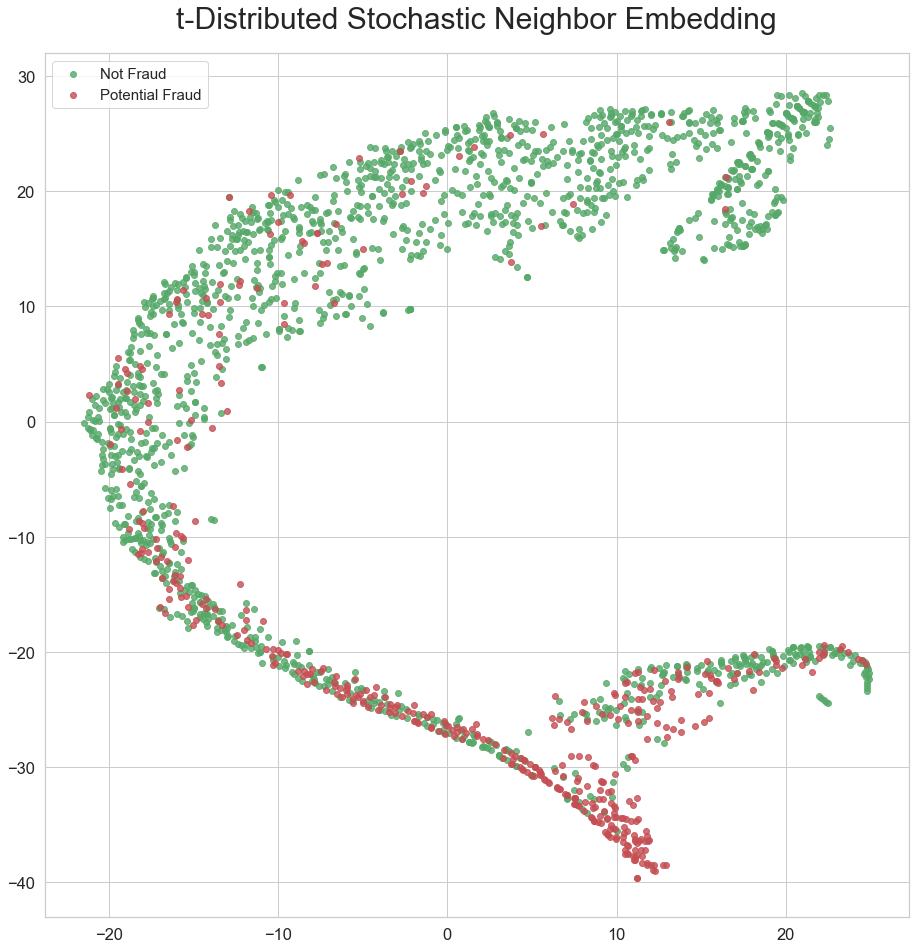

In [426]:
# scatterplot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(Xtsne[np.where(y_b.values == 0), 0], Xtsne[np.where(y_b.values == 0), 1],
           marker='o', color='g', linewidth=1, alpha=0.8, label='Not Fraud')
ax.scatter(Xtsne[np.where(y_b.values == 1), 0], Xtsne[np.where(y_b.values == 1), 1],
           marker='o', color='r', linewidth=1, alpha=0.8, label='Potential Fraud')
ax.legend(loc='best')
plt.title('t-Distributed Stochastic Neighbor Embedding')